Telco müşterikaybı verileri, üçüncü çeyrekte Kaliforniya'daki 7043 müşteriye ev telefonu ve İnternet hizmetleri sağlayan hayali bir telekom şirketi hakkında bilgi içerir. Hangi müşterilerin hizmetlerinden ayrıldığını, kaldığını veya hizmete kaydolduğunu gösterir.
Şirketi terk edecek müşterileri tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir.  Modeli geliştirmeden öncegerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

In [215]:
import pandas as pd
import numpy as np
df=pd.read_csv("Telco-Customer-Churn.csv")

Adım 1:Genel resmi inceleyiniz

In [216]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [218]:
df.head()
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Adım 2: Numerik ve kategorik değişkenleri yakalayınız.

In [219]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
num_col=[i for i in df.columns if df[i].dtypes !="O"]


In [220]:
num_but_cat=[i for i in df.columns if df[i].dtypes!="O" and df[i].nunique()<=2]
num_but_cat

['SeniorCitizen']

In [221]:
num_col=[col for col in num_col if col not in "SeniorCitizen"]
num_col

['tenure', 'MonthlyCharges', 'TotalCharges']

In [222]:
df= pd.get_dummies(df, columns=["Churn"], drop_first=True)
cat_col=[col for col in df.columns if df[col].dtypes =="O"]
cat_col=[col for col in cat_col if col not in "customerID"]
cat_col #total_charges numeric olması gerekirken object türünde bu yüzden onun veri türünü değiştirmeliyim

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

Adım 4:Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)

In [223]:
for i in num_col:
    a=df.groupby("Churn_Yes").agg({i:"mean"})
    print(a)

              tenure
Churn_Yes           
0          37.569965
1          17.979133
           MonthlyCharges
Churn_Yes                
0               61.265124
1               74.441332
           TotalCharges
Churn_Yes              
0           2555.344141
1           1531.796094


In [224]:
for i in cat_col:
    result=df.groupby(df[i]).agg({"Churn_Yes":"mean"})
    print(result)

        Churn_Yes
gender           
Female   0.269209
Male     0.261603
         Churn_Yes
Partner           
No        0.329580
Yes       0.196649
            Churn_Yes
Dependents           
No           0.312791
Yes          0.154502
              Churn_Yes
PhoneService           
No             0.249267
Yes            0.267096
                  Churn_Yes
MultipleLines              
No                 0.250442
No phone service   0.249267
Yes                0.286099
                 Churn_Yes
InternetService           
DSL               0.189591
Fiber optic       0.418928
No                0.074050
                     Churn_Yes
OnlineSecurity                
No                    0.417667
No internet service   0.074050
Yes                   0.146112
                     Churn_Yes
OnlineBackup                  
No                    0.399288
No internet service   0.074050
Yes                   0.215315
                     Churn_Yes
DeviceProtection              
No                   

Adım 5: Aykırı gözlem analizi yapınız.

In [246]:
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quantile1=dataframe[col_name].quantile(q1)
    quantile3=dataframe[col_name].quantile(q3)
    interquantile_range=quantile3-quantile1
    up_limit=quantile3+1.5*interquantile_range
    low_limit=quantile1-1.5*interquantile_range
    return low_limit,up_limit

def check_outlier(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit)].any(axis=None):
        return True
    else:
        return False
def replace_with_thresholds(dataframe,variable):
    low_limit,up_limit=outlier_thresholds(dataframe,variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [226]:
for i in cat_col:
    df= pd.get_dummies(df, columns=[i], drop_first=True)
df.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,0,34,56.95,1889.50,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [235]:
df.isnull().sum()

SeniorCitizen                            0
tenure                                   0
MonthlyCharges                           0
TotalCharges                             0
Churn_Yes                                0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
PhoneService_Yes                         0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV_Yes                          0
StreamingMo

In [232]:
df.drop("customerID",axis=1,inplace=True)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.013889,0.115423,0.001275,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.215867,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.010310,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.210241,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.015330,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [233]:
from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=5)
df=pd.DataFrame(imputer.fit_transform(df),columns=df.columns)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.013889,0.115423,0.001275,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.215867,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.010310,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.210241,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.015330,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


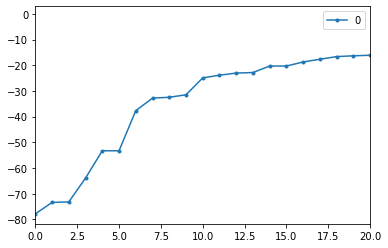

In [244]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
clf=LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores=clf.negative_outlier_factor_
scores=pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0,20],style='.-')
plt.show()

In [248]:
for i in df.columns:
    print(i,check_outlier(df,i))

SeniorCitizen False
tenure False
MonthlyCharges False
TotalCharges False
Churn_Yes False
gender_Male False
Partner_Yes False
Dependents_Yes False
PhoneService_Yes False
MultipleLines_No phone service False
MultipleLines_Yes False
InternetService_Fiber optic False
InternetService_No False
OnlineSecurity_No internet service False
OnlineSecurity_Yes False
OnlineBackup_No internet service False
OnlineBackup_Yes False
DeviceProtection_No internet service False
DeviceProtection_Yes False
TechSupport_No internet service False
TechSupport_Yes False
StreamingTV_No internet service False
StreamingTV_Yes False
StreamingMovies_No internet service False
StreamingMovies_Yes False
Contract_One year False
Contract_Two year False
PaperlessBilling_Yes False
PaymentMethod_Credit card (automatic) False
PaymentMethod_Electronic check False
PaymentMethod_Mailed check False


customerID                                0
SeniorCitizen                             0
tenure                                    0
MonthlyCharges                            0
TotalCharges                             11
Churn_Yes                                 0
gender_Male                               0
Partner_Yes                               0
Dependents_Yes                            0
PhoneService_Yes                          0
MultipleLines_No phone service            0
MultipleLines_Yes                         0
InternetService_Fiber optic               0
InternetService_No                        0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service           0
TechSupport_Yes                           0
StreamingTV_No internet service 

In [211]:
for i in cat_col:
    print(i)

gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod


In [252]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = df["Churn_Yes"]
X = df.drop(["Churn_Yes"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.780407004259347